# Neural Network Final Model

In [8]:
import pandas as pd
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [9]:
site = config.site
site_name = config.site_dict[site]
compound = config.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Mace Head, Ireland.


### Loading & Initialising Data

In [10]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_2_past,v500_3_past,v500_4_past,v500_5_past,v500_6_past,v500_7_past,v500_8_past,v500_13_past,v500_14_past,v500_15_past
12952,1998-04-12 21:00:00,1.0,-0.492588,-1.459531,-0.227481,1.580131,1.709196,3.081474,5.129077,-0.250503,...,-1.922535,-12.196097,-9.545477,-31.471990,-29.227335,-34.153725,-28.196127,-29.534030,-10.401854,-19.940530
38266,2016-10-19 11:00:00,1.0,1.178337,1.310433,1.000515,3.332521,-0.483591,-2.405761,-3.461966,-0.270770,...,-27.594944,-22.762785,-10.893583,-4.377347,-0.793212,-0.204058,0.182788,-3.699342,-1.063868,9.160896
18230,2001-12-03 05:00:00,1.0,-0.572872,-2.460939,-2.648267,-0.132722,-0.670057,6.443471,7.488563,4.039900,...,9.692261,1.227780,-0.001223,4.248893,2.546165,16.108402,17.090115,3.186737,-10.344217,19.136965
1588,1989-12-05 17:00:00,0.0,-6.272148,3.948664,2.136580,-4.137915,-10.325299,-11.952476,-12.141492,-5.404320,...,0.747110,-0.818177,-2.534185,0.131671,8.206171,0.825611,8.231292,7.582882,-7.540910,9.097931
42632,2020-03-01 15:00:00,1.0,10.254580,-1.733707,6.698659,8.934054,9.962376,15.231284,15.515574,13.750476,...,-2.600762,3.314376,3.122327,-5.936029,-2.455124,-2.317488,-3.953114,-4.378824,-9.903461,0.950561


In [11]:
if site == "MHD":
    train_data = data[(data['time'].dt.year >= 2014) & (data['time'].dt.year <= 2018)]
    val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
    test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]

if site == "GSN":
    train_data = data[(data['time'].dt.year >= 2009) & (data['time'].dt.year <= 2013)]
    val_data = data[(data['time'].dt.year >= 2014) & (data['time'].dt.year <= 2014)]
    test_data = data[(data['time'].dt.year >= 2015) & (data['time'].dt.year <= 2017)]


print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")

# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])


# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']


# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2014-01-01 03:00:00 -> 2018-12-31 01:00:00. Length: 6851
Val range: 2019-01-04 05:00:00 -> 2019-12-30 13:00:00. Length: 1067
Test range: 2020-01-02 17:00:00 -> 2022-12-31 19:00:00. Length: 3985


### Model

In [12]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(100,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.05, 
                         learning_rate='constant', 
                         batch_size=100, 
                         early_stopping=True,
                         learning_rate_init=0.001,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

y_pred_val = nn_model.predict(X_val)
y_pred_train = nn_model.predict(X_train)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.884
Precision on Validation Set = 0.821
Recall on Training Set = 0.973
Recall on Validation Set = 0.962
F1 Score on Training Set = 0.926
F1 Score on Validation Set = 0.886


In [13]:
# evaluating model on test set

y_pred_test = nn_model.predict(X_test)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")

Precision on Testing Set = 0.883
Recall on Testing Set = 0.968
F1 Score on Testing Set = 0.924


In [14]:
# finding most important features in the model using permutation importance
# using the testing set
perm_importance = permutation_importance(nn_model, X_train, y_train, n_repeats=30, random_state=42)
sorted_importances = perm_importance.importances_mean.argsort()

Text(0.5, 1.0, 'Permutation Importance (Testing Set)')

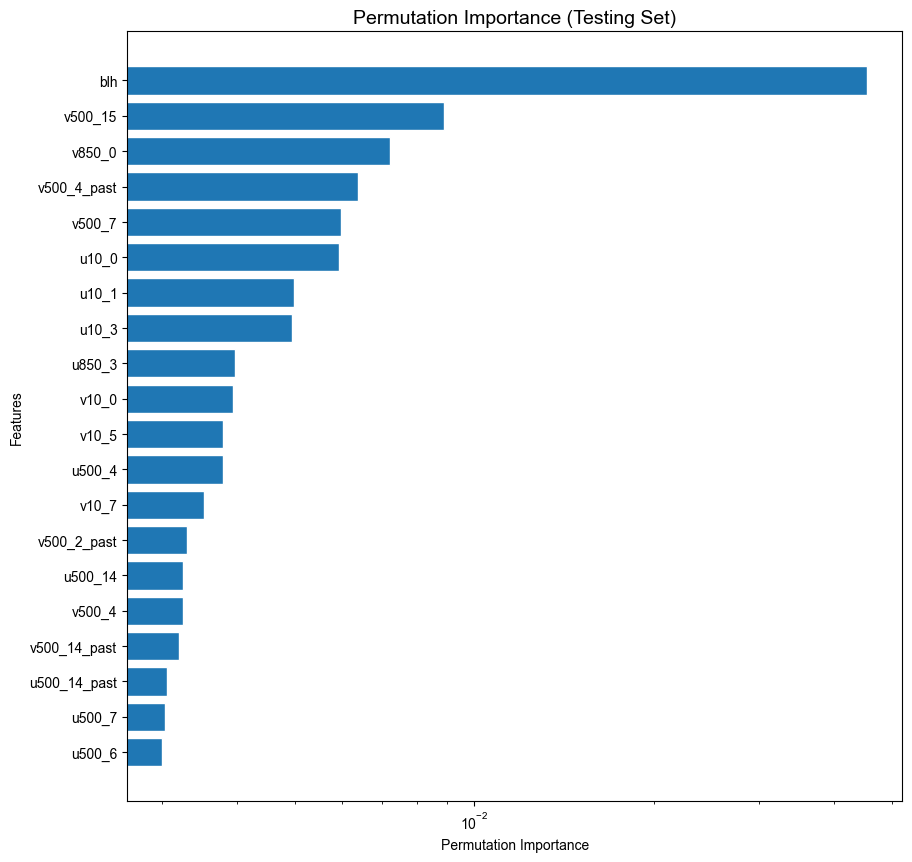

In [15]:
# plotting first 20 most important features in a histogram

fig, ax = plt.subplots(figsize=(10, 10))
sns.set(style="whitegrid")
sns.set_palette("viridis")

ax.barh(X_val.columns[sorted_importances][-20:], perm_importance.importances_mean[sorted_importances][-20:])

ax.set_xscale('log')

ax.set_ylabel('Features')
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance (Testing Set)', fontsize=14)

In [16]:
# saving the model
dump(nn_model, data_path/f'nn_model_{site}.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\nn_model_MHD.joblib']